# Measuring and predicting posts success for tumblr/design/fashion bloggers

Social media influencers, individuals who have stablished credibility in a specific industry, are becoming a fundamental piece in marketing campaigns for various industries, including fashion, beauty and lifestyle. According to statistics reported in the Fashion Monitor and Econsultancy report, fashion marketers reported allocating between 30% and 75% of their total marketing budget to influencer marketing, looking for influencers with small but consistent audiences to those with hundreds of thousands of followers, depending mostly on the brand and the targeted audience. 

It is however a very competitive job, and while some will flourish effortlessly, others can struggle to gain traction. There are many variants an influencer starter should focus on, many of such depending on the brands and audience the influencer wishes to attract, and one of those is how to compose each post, such that it maximizes its influence. What should an influencer focus on when beginning his or her blog or social media posts? 

I wanted to understand and find out what insights we could gain on a composition of a post and the level of influence, from looking at the data. In this project I explore and analyse data collected from Tumblr, a blog repository, to find insights that help improve a post influence in the social media platform.

# Collecting data

1. The data will be colected from Tumblr Api 
2. Tumblr Api is a generous API that enables the developer to request 1000 queries every hour up to 5 hours, and depending on the users privacy settings, all information relevant to blogs, posts of a particular user or tags of a particular subject.
3. For the purposes of my project, I want to explore the tagged data for a particular subject in design/fashion bloggers, such as street style (which presumibly includes men, women)
4. My hypothesis is that there should be a measure of success for a particular post, based on different features given by the data.


The following lines of code make one 'tagged' request for 20 posts (default value)

The following script collects data for a particular 'tag' or subject in cycles. Each request the developer can make to Tumblr API is for the most recent posts, starting on a date given by the developer. That means that we have to request in a loop that traces back to the last post collected, stores its date and redefines the last date as this new stored date.

In [8]:
%%writefile postGather_tag.py
from __future__ import division
import pandas as pd
import numpy as np

import sys
import time

#API:
import pytumblr

#Personal package:
import cleaning

#Generator to grab posts from a series of hashtags:
def PostGenerator(client, tag, timelist = [],rep = 1):
    """Generator to get posts from Tumblr API.
    client = tumblr client
    tag = tag to search for
    timelist = times to search at
    rep = repetition rate, if using timelist
    """
    
    #Grab 20 or less:
    chunk=20
    #Just a counter:
    i=0
    j=0
    #For now, start at current time:
    last_stamp =time.time() #seconds since 1970

    #Total time measured:
    elapsed=0

    #magic infinite generator (for as long as needed):
    while True:

        #If we're using a timelist, and it's time for a new timestamp:
        if (i%rep==0) and (len(timelist)>0): #i mod r when rep is met

            #We've run past the stamp!
            if (last_stamp < timelist[j]):
                print "WARNING: %d < %d; will later drop duplicates" \
                    % (last_stamp,timelist[j])

            #New last stamp:
            new_before = timelist[j] - 1
            j += 1 #Increment

        else:
            new_before = last_stamp #New last stamp

        #Print out some progress every 20 calls:
        if (i%20)==0: #when 20 is met
            print "%d..." % i,

        #Only more recent than start of Jan, 2013:
        #if (new_before < 1356998400):
        #    print "Past date"
        #    yield None, 0, 0
        
        #Posts with tag, starting at last_stamp:
        #print "Looking before",new_before
        posts = client.tagged(tag, limit=chunk, before=new_before)
        #posts = client.post(post, limit=chunk, before=new_before)
        #print i,j,last_stamp
        
        #Didn't get anything
        if not posts:
            print "Out of posts"
            yield None, 0, 0
        else:
            elapsed = posts[0]['timestamp'] - posts[len(posts)-1]['timestamp']# compare between first and last 
            if elapsed < 0:
                print "WARNING: final %d < initial %d" % (posts[len(posts)-1]['timestamp'], posts[0]['timestamp'])
            #print "First post at %d, last post at %d" % (posts[0]['timestamp'],posts[len(posts)-1]['timestamp'])
            #Reset the time stamp to that of the oldest:
            last_stamp = posts[len(posts)-1]['timestamp']
            #YIELD
            yield posts,last_stamp,[elapsed/len(posts)]*len(posts)

        #Counters:
        i += 1
        


def FrontendGetPosts(tag,npost):

    consumer_key = 'zl9VsMpQcExcL1DptEqHFYHnmUVgr33wb29ygB6NU2BxYpLKFU'
    consumer_secret = 'aDFAwVWEDtvVA02CY9oe8HiUAoP9LcYVECjvQIG5rAa4RK4yJX'
    oauth_token = 'EkSwbxg1E09rMQWNXUnvOwmKncuwrSF98RuVSVctdbgKATi1Yi'
    oauth_secret = '0Khms8Q0Q6OWSQTARmFHATcTjchcZmGFQYrSbjZhmBKlbFT5jp'
    
    client = pytumblr.TumblrRestClient(consumer_key,consumer_secret, \
        oauth_token, oauth_secret)
    
    #Lists to hold all the posts:
    all_posts = []
    
    #Generator to grab posts from tag:
    post_gen = PostGenerator(client,tag)
    
    post_lim = int(npost/20)
    
    #First, grab the total posts (up to 1000 worth):
    for _ in range(0,post_lim):

        time.sleep(0.1) #Don't hit the API rate limit
        
        #Grab posts, plus stamp and elapsed information
        posts,ts,te = post_gen.next()

        #When we're out of posts:
        if not posts:
            break
        
        #Append list of posts:
        all_posts += posts    

    df_all = pd.DataFrame(all_posts)
    df_all = df_all.replace(np.nan,' ', regex=True)
    df = df_all[['id']].copy()
    #cols=['blog_name','liked', 'followed','id', 'note_count','short_url','slug','tags','timestamp','type']
    #df.loc[:,cols]
    #df=df_all.loc[:,cols]
    #df.loc[df['type'] == 'photo']
    #df=df_all
    df.loc[:,'num_photos']=df_all.apply(cleaning.count_photos,axis=1)
    df.loc[:,'photo_ratio']=df_all.apply(cleaning.ratio,axis=1)
    df.loc[:,'words'] = df_all.apply(cleaning.cleaner,axis=1)
    df.loc[:,'wcount'] = df_all.apply(cleaning.count,axis=1)
    df.loc[:,'taglist'] = df_all.apply(cleaning.gather_tags,axis=1)
    df.loc[:,'cphotos']=df_all.apply(cleaning.gather_tags,axis=1)
    df.loc[:,'blog_name'] = df_all['blog_name'].astype(str)
    df.loc[:,'date'] = df_all['date']
    df.loc[:,'note_count'] = df_all['note_count']
    df.loc[:,'short_url'] = df_all['short_url']
    df.loc[:,'source_title']=df_all['source_title'].astype(str)
    df.loc[:,'photoset_layout']=df_all['photoset_layout']
    

    return df # df.to_csv(fl,index='true')

Overwriting postGather_tag.py


The following script cleans the variables for each data point collected. I extract the text with beatiful soup and clean/process the text performing lemmatization and removing stopwords. I also create a word count variable, defined as the number of processed words wach post has.

In [ ]:
# %load cleaning.py
from bs4 import BeautifulSoup  
import re
import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def make_text(x):
    """Concatenate tumblr text fields from post x
    wtitle = include title?
    """
        
    tot_txt = ""

    #Add together various fields based on type:
    if x['type'] == 'text':    
        tot_txt = x['body']
    elif x['type'] == 'photo':
        tot_txt= x['caption']
    elif x['type'] == 'answer':
        tot_txt = x['question'] + x['answer']
    elif x['type'] == 'chat':
        tot_txt = ""#x['text']#""

    #Clean out html:
    soup = BeautifulSoup(tot_txt,'html')
        
    return soup.get_text()

def cleaner(x):
    """Clean text x by removing non-alphanumerics and case, and lemmatizing.
    wtitle = include title?
    """
    
    post_txt=make_text(x)

    # Use regular expressions to do a find-and-replace
    letters_only = re.sub("[^a-zA-Z]"," ", post_txt )  # The text to search

    #Lower-bcase"
    lower_case = letters_only.lower()        # Convert to lower case

    #split them up:
    words = lower_case.split(" ")
    str_return=""

    #Lemmatizer!
    wnl = WordNetLemmatizer()

    #Loop over words, remove stopwords and lemmatize before re-joining:
    for w in words:
        if (len(w) > 1) and (w not in stopwords.words("english")):
            str_return += wnl.lemmatize(w)
            str_return += " "

    #Encde as ascii:
    return str_return.encode('ascii')

def count(x):
    """Count words in x.
    """
          
    post_txt=make_text(x)

    count = len(re.findall(r'\w+', post_txt))
    return count

def gather_tags(x):
    """Grab tags in x, clean them, and turn them into a list of quoted strings.
    """
        
    tag_txt = ""
    
    for t in x['tags']:
        t = re.sub("[^a-zA-Z ]","", t )
        t = t.lower()  
        words = t.split(" ")
        str_return=""
        wnl = WordNetLemmatizer()
    
        for w in words:
            if (len(w) > 1) and (w not in stopwords.words("english")):
                str_return += wnl.lemmatize(w)
                str_return += " "   

        tag_txt += '"%s",' % str_return
    return tag_txt.encode('ascii')

def count_photos(x):
    """Count photos in x
    """
    count=len(x['photos'])
    return count


def ratio(x):
    """ratio or mean of ratios
    """
    
    ratios=[]
    if len(x['photos']) > 1:
        for i,photo in enumerate(x['photos']):
            ratios.append(float(x['photos'][i]['original_size']['height'])/(x['photos'][i]['original_size']['width']))
        rat=np.mean(ratios)
    elif x['photos']!=' ' :
        rat=float(x['photos'][0]['original_size']['height'])/(x['photos'][0]['original_size']['width'])
        #print x['photos'][0]['original_size']['height']
    else:
        rat=' '
    return rat

    





In [2]:
%run postGather_tag.py

%run cleaning.py

Using the helping functions defined above, I collected around 80000 posts.

In [1]:
#Data collection



#street_style_w3=FrontendGetPosts('street style',10000)
#street_style_w3.to_csv('street_style_w3',encoding='utf-8')
#streetstyle_w3=FrontendGetPosts('streetstyle',10000)
#streetstyle_w3.to_csv('streetstyle_w3',encoding='utf-8')
#menfashion=FrontendGetPosts('menfashion',10000)
#menfashion.to_csv('menfashion',encoding='utf-8')
#menswear=FrontendGetPosts('menswear',10000)
#menswear.to_csv('menswear',encoding='utf-8')
#mens_style=FrontendGetPosts('mens style',10000)
#mens_style.to_csv('mens_style',encoding='utf-8')
#mensfashion=FrontendGetPosts('mensfashion',10000)
#mensfashion.to_csv('mensfashion',encoding='utf-8')
#mens_wear=FrontendGetPosts('mens_wear',10000)
#mens_wear.to_csv('mens_wear',encoding='utf-8')

#curvy_style=FrontendGetPosts('curvy style',1000)
#curvy_style.to_csv('curvy_style',encoding='utf-8')

#fashion=FrontendGetPosts('fashion',20000)
#fashion.to_csv('fashion',encoding='utf-8')
#high_fashion=FrontendGetPosts('high fashion',10000)
#high_fashion.to_csv('high fashion',encoding='utf-8')


# Exploratory analysis

In [3]:
# ! ls

In [1]:
# load some modules
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import missingno as msn
from datetime import datetime
from matplotlib import rcParams
import warnings
import sys
import time
import math
warnings.filterwarnings('ignore')
# Plotting styles
rcParams['figure.figsize'] = (8, 5)
#sns.set_style('darkgrid')

Extracting the data

In [2]:
streetstyle_w2=pd.read_csv('data/streetstyle_w2')
street_style_w2=pd.read_csv('data/street_style_w2')
streetstyle=pd.read_csv('data/streetstyle_w3')
street_style=pd.read_csv('data/street_style_w3')
#list(streetstyle)
mens_wear=pd.read_csv('data/mens_wear_w3')
menswear=pd.read_csv('data/menswear_w3')
mensfashion=pd.read_csv('data/menfashion_w3')
mensfashion=pd.read_csv('data/mensfashion_w3')
fashion=pd.read_csv('data/fashion_w3')
high_fashion=pd.read_csv('data/high fashion_w3')
curvy_style=pd.read_csv('data/curvy_style')

Joining different datasets

In [3]:
#streetstyle.head

ststyle=pd.concat([streetstyle,street_style,mens_wear,menswear,mensfashion,mensfashion,fashion,high_fashion,street_style_w2,streetstyle_w2,curvy_style])
#ststyle=pd.concat([streetstyle_w2,street_style_w2])

len(ststyle)

print 'Unique records: %d' %(len(ststyle))
print 'Set of sources: %d'%(len(set(ststyle['source_title'])))
print 'Set of list of words %d'%(len(set(ststyle['words'])))
print 'Set of list of wcounts %d'%(len(set(ststyle['wcount'])))
print 'Set of list of tags %d'%(len(set(ststyle['taglist'])))
print 'Set of list of captions %d'%(len(set(ststyle['cphotos'])))
print 'Set of layouts %d'%(len(set(ststyle['photoset_layout'])))
print 'Set of note_counts %d'%(len(set(ststyle['note_count'])))
print 'Set of urls %d'%(len(set(ststyle['short_url'])))
print 'Set of bloggers %d'%(len(set(ststyle['blog_name'])))



Unique records: 83283
Set of sources: 1078
Set of list of words 30789
Set of list of wcounts 486
Set of list of tags 41617
Set of list of captions 41617
Set of layouts 179
Set of note_counts 1836
Set of urls 57308
Set of bloggers 11317


In [4]:
list(ststyle)

['Unnamed: 0',
 'id',
 'num_photos',
 'photo_ratio',
 'words',
 'wcount',
 'taglist',
 'cphotos',
 'blog_name',
 'date',
 'note_count',
 'short_url',
 'source_title',
 'photoset_layout']

Transform note_count variable (due to the wide range) to a log scale.

In [5]:

#ststyle.head()
ststyle['note_countlog']=ststyle['note_count'].transform(lambda x: math.log10(x+1))

### Tagging the data

#### Binary outcome

In [6]:
med=ststyle['note_count'].median()
mu=ststyle['note_count'].mean()
se=ststyle['note_count'].std()/(math.sqrt(83283))
q_8=ststyle['note_count'].quantile(q=.8)

print 'Median, mean, standard deviation, 99th quantile, 80th quantile: %.2f,%.2f,%.2f,%.2f,%.2f'%(round(med),int(mu),se,mu+3*se,q_8)


print 'How many have more than .99 of data:%.2f'%(len(ststyle.loc[ststyle['note_count']>(mu+3*se)]))

Median, mean, standard deviation, 99th quantile, 80th quantile: 2.00,253.00,33.34,353.78,28.00
How many have more than .99 of data:2684.00


Tag 'followed' as those with more than 28 note counts (20% of the data)

In [7]:
ststyle['Followed']=ststyle['note_count'].transform(lambda x: True if x > q_8-1 else False )
ststyle['Followed'].sum()

16880

Distribution of number of notes per posts

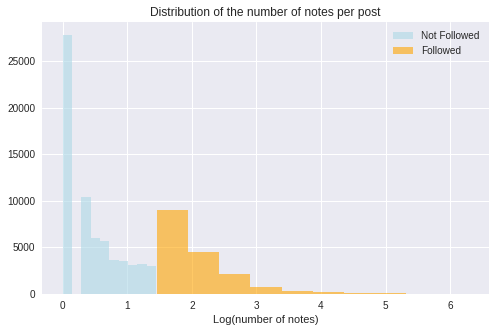

In [8]:
#sns.distplot(ststyle.note_countlog[
#    (ststyle.Followed==0)],
#             label='Not Followed')
#sns.distplot(ststyle.note_countlog[
#    (ststyle.Followed==1)],
#             label='Followed')
fig,ax=plt.subplots()
ststyle['note_countlog'][ststyle.Followed==0].hist(color='lightblue',alpha=.6, 
                              label='Not Followed')
ststyle['note_countlog'][ststyle.Followed==1].hist(color='orange',alpha=.6, 
                              label='Followed')
plt.xlabel('Log(number of notes)')
plt.title('Distribution of the number of notes per post')
plt.legend()

In [9]:
ststyle.Followed.value_counts()

False    66403
True     16880
Name: Followed, dtype: int64

In [10]:
#import ggplot 
#from ggplot import *

#ggplot(aes(x='note_countlog',fill='Followed'), data=ststyle) +geom_histogram() \
#+ theme(axis_title_x=element_text(size=20,text='Log10(Number of notes)'),\
#        axis_title_y=element_text(size=20,text='Counts'),\
#        plot_title=element_text(size=20,text="Distribution of the number of notes for the posts"))+\
#scale_fill_brewer(palette=3)

In [11]:
print len(ststyle)
print max(ststyle['note_count'])
#print 27824./83283  #for all files
#print 30964./83283
#print 24495./83283


83283
1920599


#### Multiclass classification

It is probably more useful to the user to compare with unpopular, semi-popular and popular posts. This is why I will classify the outcome in three classes: not followed, followed and popular, based on the 40th and 70th quantiles.

In [12]:
cuta=ststyle['note_count'].quantile(q=.4)
cutb=ststyle['note_count'].quantile(q=.7)


print [cuta,cutb]


print len(ststyle.loc[ststyle['note_count']<cuta])
print len(ststyle.loc[(cuta<=ststyle['note_count'])&(ststyle['note_count']<=cutb)])
print len(ststyle.loc[ststyle['note_count']>cutb])

[1.0, 11.0]
27824
30964
24495


In [13]:
ststyle['Popularity']=pd.cut(ststyle['note_count'], [0, 1, 11, np.inf], labels=['notfollowed','relfollowed','popular'])

ststyle['Popularity']=np.where(ststyle['note_count'] > 11, 'Popular', 
         (np.where(ststyle['note_count'] < 1, 'NotFollowed', 'Followed')))

#### Some transformations of the variables

In [14]:
set(ststyle['photoset_layout'])
s=set(ststyle['photoset_layout'])
dic={s:i for i, s in enumerate(set(ststyle['photoset_layout']))}
ststyle=ststyle.replace({'photoset_layout': dic})
ststyle['photoset_layout'] =ststyle['photoset_layout'].apply(str)

In [15]:
ststyle['note_countlog']=ststyle['note_count'].transform(lambda x: math.log10(x+1))
ststyle['num_photos']=ststyle['num_photos'].astype(float)
ststyle['wcount']=ststyle['wcount'].astype(float)
ststyle['photo_ratio']=pd.to_numeric(ststyle['photo_ratio'], errors='coerce')
ststyle['hour']=[pd.to_datetime(item).hour for item in ststyle['date']]
ststyle['Date_']=pd.to_datetime(ststyle['date'])
#ststyle['Date_']=[pd.to_datetime(item) for item in ststyle['date']]
ststyle_sort=ststyle.sort_values(by='Date_',ascending=False)

Length of the data collection

In [16]:
#print max(ststyle.Date_)-min(ststyle.Date_)
# 577 days

In [17]:
#ststyle[ststyle.Date_==min(ststyle.Date_)].count()

Missing values

In [18]:
ststyle['photo_ratio'].isnull().sum()

2634

### Distributions

Note count vs photoset layout, which is the most popular?

In [19]:
#list(ststyle)

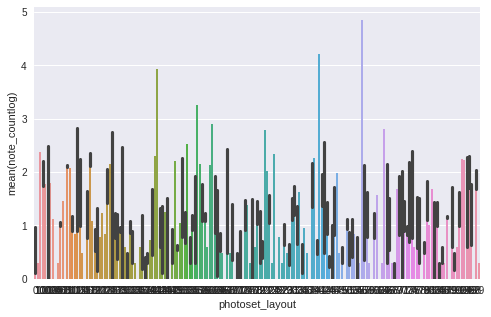

In [16]:
sns.barplot(x='photoset_layout',y='note_countlog',data=ststyle)

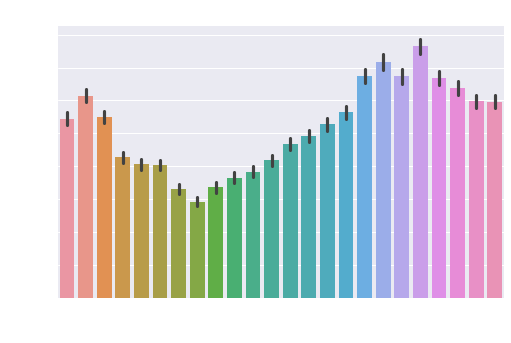

In [58]:
sns.barplot(x='hour',y='note_countlog',data=ststyle, estimator=sum)
ax=plt.gca()
plt.title("Notes per hour of the day",color='white',size=18)
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['left'].set_color('white')
ax.spines['right'].set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
plt.ylabel('Log(note count)',color='white',size=18)
plt.xlabel('Hour of the day',color='white',size=18)
fig=plt.gcf()
fig.savefig('hour_02_17.png', transparent=True)
plt.show()

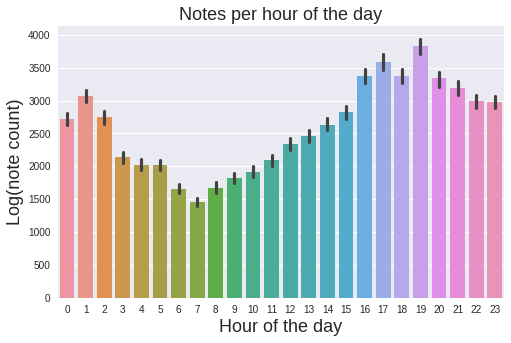

In [20]:
sns.barplot(x='hour',y='note_countlog',data=ststyle, estimator=sum)
ax=plt.gca()
plt.title("Notes per hour of the day",size=18)
plt.ylabel('Log(note count)',size=18)
plt.xlabel('Hour of the day',size=18)
fig=plt.gcf()
fig.savefig('hour_02_17_default.png', transparent=True)
plt.show()

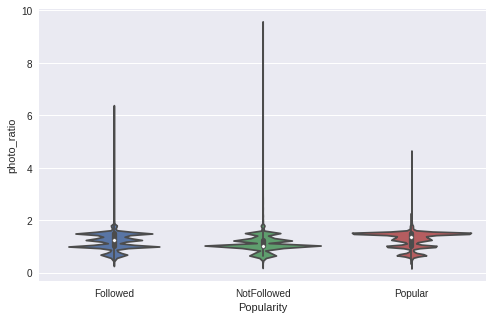

In [150]:
sns.violinplot(x='Popularity',y='photo_ratio',data=ststyle)

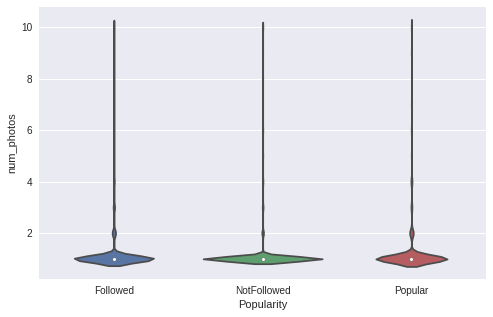

In [153]:
sns.violinplot(x='Popularity',y='num_photos',data=ststylesns.violinplot(x='Popularity',y='photo_ratio',data=ststyle))

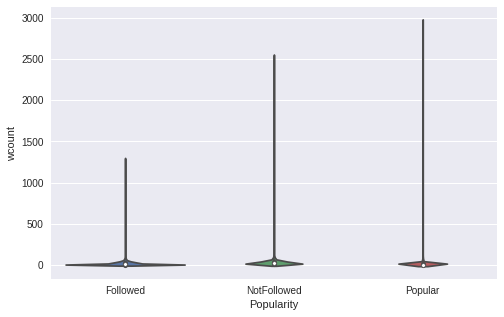

In [154]:
sns.violinplot(x='Popularity',y='wcount',data=ststyle)

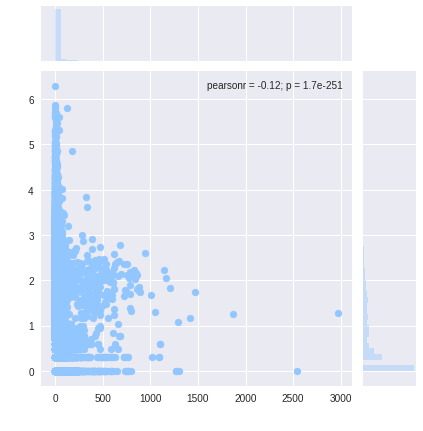

In [67]:
sns.color_palette('pastel')
sns.jointplot(x="wcount", y="note_countlog", data=ststyle).set_axis_labels("Word count", "Log(note count)",size=18,color='white')
ax=plt.gca()
#plt.title("Word count vs note count",color='white',size=18)
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['left'].set_color('white')
ax.spines['right'].set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
fig=plt.gcf()
fig.savefig('word_count_02_17.png', transparent=True)
plt.show()

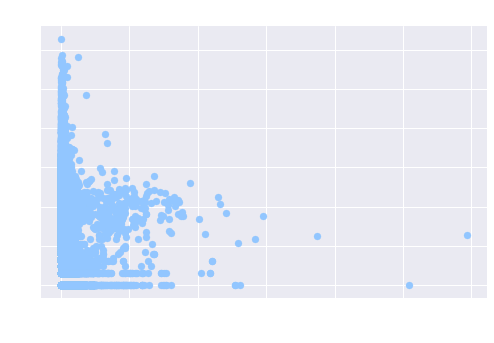

In [69]:

plt.scatter(x="wcount", y="note_countlog", data=ststyle)
ax=plt.gca()
plt.title("Word count vs note count",color='white',size=18)
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['left'].set_color('white')
ax.spines['right'].set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
plt.xlabel('Word count',color='white',size=18)
plt.ylabel('Log(note count)',color='white',size=18)
fig=plt.gcf()
fig.savefig('word_count_02_17.png', transparent=True)
plt.show()

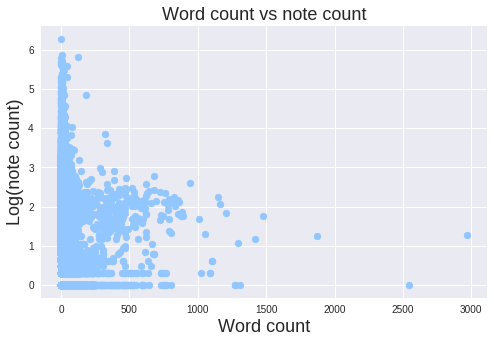

In [48]:
plt.scatter(x="wcount", y="note_countlog", data=ststyle)
ax=plt.gca()
plt.title("Word count vs note count",size=18)
plt.xlabel('Word count',size=18)
plt.ylabel('Log(note count)',size=18)
fig=plt.gcf()
fig.savefig('word_count_02_17_default.png')#, transparent=True)
plt.show()

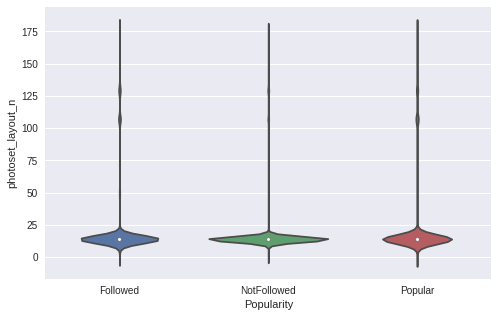

In [156]:
ststyle['photoset_layout_n']=ststyle['photoset_layout'].astype('int')
sns.violinplot(x="Popularity", y="photoset_layout_n", data=ststyle)


### Interesting features we could add: 

1. Gather in a handful of users (most frequent) 
2. Gather in a handful of tags? (most frequent)  
    This could be interesting, could impact brand marketing



### Feature engineering (other than former transformations)

#### Frequent bloggers

In [22]:
frq_blogs=pd.DataFrame(ststyle['blog_name'].value_counts())  
len(frq_blogs)
### I have to revise if the frequent users posts are produced each in a single day!!!!!!!!!!!!!!!!!!! 

11317

In [23]:
frq_blogs['names'] = frq_blogs.index
frq_blogs=frq_blogs.rename(index=str, columns={"blog_name": "Frequency", "names": "names"})
print frq_blogs['Frequency'].mean()
list(frq_blogs)
frq_blogs.info()
thresh=frq_blogs.quantile(q=.7)[0]
print thresh

7.35910577008
<class 'pandas.core.frame.DataFrame'>
Index: 11317 entries, mensstreet to kidego
Data columns (total 2 columns):
Frequency    11317 non-null int64
names        11317 non-null object
dtypes: int64(1), object(1)
memory usage: 265.2+ KB
3.0



So around 80 % of bloggers have less than 3 posts in this period of time.

I will asume that any user blog with more than 'thresh' is frequent.


Let's see the distribution of frequent users

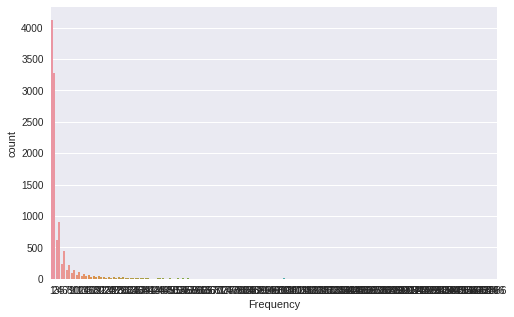

In [172]:
sns.countplot(frq_blogs.Frequency)

In [24]:
df_freq=frq_blogs[frq_blogs['Frequency']>thresh]
list(df_freq)
#df_freq['names'].tolist()

['Frequency', 'names']

In [25]:
len(df_freq)
isfreq=ststyle['blog_name'].isin(df_freq['names'].tolist())
#ststylefreq=ststyle[ststyle['blog_name'].isin(df_freq['names'].tolist()),]
#ststylenfreq=stsyle[~ststyle['blog_name']%in% df_freq['names'],]

ststyle['isfreq']=isfreq.astype(int)
#frequency for each blog_name, I will have to 

In [26]:
ststyle['isfreq'].sum()

70721L

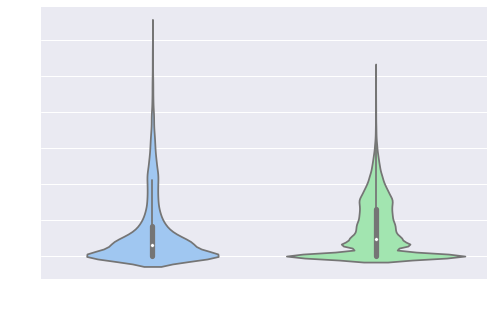

In [115]:
sns.set_palette("pastel")
sns.violinplot(x='isfreq',y='note_countlog',data=ststyle)
ax=plt.gca()
plt.title("",color='white',size=18)
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['left'].set_color('white')
ax.spines['right'].set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
plt.xlabel('Is it a frequent blogger',color='white',size=18)
plt.ylabel('Log(note count)',color='white',size=18)
fig=plt.gcf()
fig.savefig('frequent_user_02_17.png', transparent=True)
plt.show()

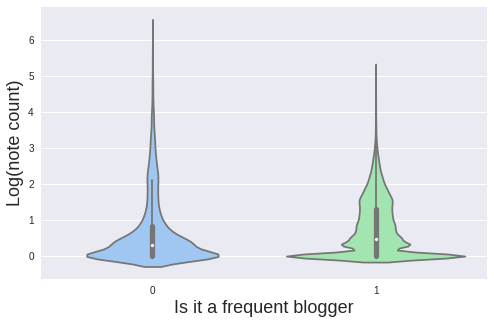

In [46]:
sns.set_palette("pastel")
sns.violinplot(x='isfreq',y='note_countlog',data=ststyle)
ax=plt.gca()
plt.title("",size=18)
plt.xlabel('Is it a frequent blogger',size=18)
plt.ylabel('Log(note count)',size=18)
fig=plt.gcf()
fig.savefig('frequent_user_02_17_default.png')
plt.show()

#### Frequent Layouts

In [28]:
frq_layouts=pd.DataFrame(ststyle['photoset_layout'].value_counts())  
len(frq_layouts)
### I have to revise if the frequent users posts are produced each in a single day!!!!!!!!!!!!!!!!!!! 

179

In [29]:
frq_layouts['layouts'] = frq_layouts.index
frq_layouts=frq_layouts.rename(index=str, columns={"photoset_layout": "Frequency", "layouts": "layouts"})
print frq_layouts['Frequency'].mean()
print list(frq_layouts)
threshl=frq_blogs.quantile(q=.5)[0]
print threshl
frq_layouts.head()

465.268156425
['Frequency', 'layouts']
2.0


,Frequency,layouts
14,77161,14
107,1719,107
129,1079,129
16,414,16
15,409,15


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41]),
 <a list of 42 Text xticklabel objects>)

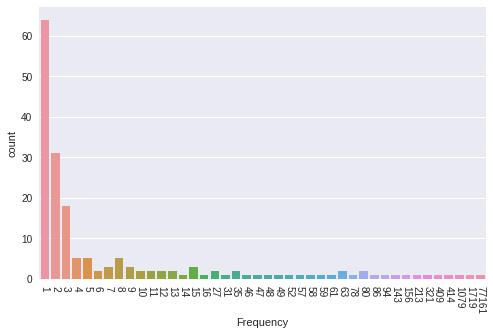

In [30]:
sns.countplot(frq_layouts.Frequency)
plt.xticks(rotation=-90)

In [32]:
lay_freq=frq_layouts[frq_layouts['Frequency']>threshl]
list(lay_freq)
#df_freq['names'].tolist()
len(lay_freq)
frq_layouts[frq_layouts['Frequency']>threshl].to_csv('freq_layout')


In [33]:

isfreql=ststyle['photoset_layout'].isin(lay_freq['layouts'].tolist())
#ststylefreq=ststyle[ststyle['blog_name'].isin(df_freq['names'].tolist()),]
#ststylenfreq=stsyle[~ststyle['blog_name']%in% df_freq['names'],]

ststyle['isfreql']=isfreql.astype(int)
#frequency for each blog_name, I will have to 

In [34]:
ststyle['aspect_ratio']=[1/item for item in ststyle['photo_ratio']]

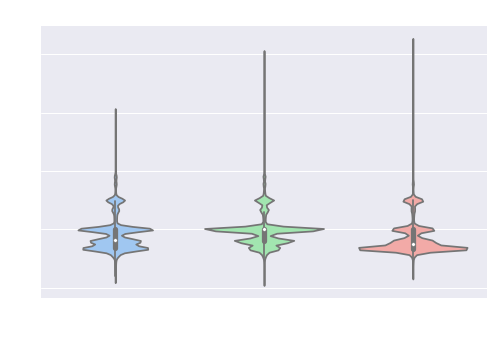

In [114]:
sns.set_palette("pastel")
sns.violinplot(x='Popularity',y='aspect_ratio',data=ststyle)
ax=plt.gca()
plt.title("Aspect ratio vs popularity",color='white',size=18)
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['left'].set_color('white')
ax.spines['right'].set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
plt.ylabel('Log(note count)',color='white',size=18)
plt.xlabel('Popularity',color='white',size=18)
fig=plt.gcf()
fig.savefig('aspect_ratio_02_17.png', transparent=True)
plt.show()

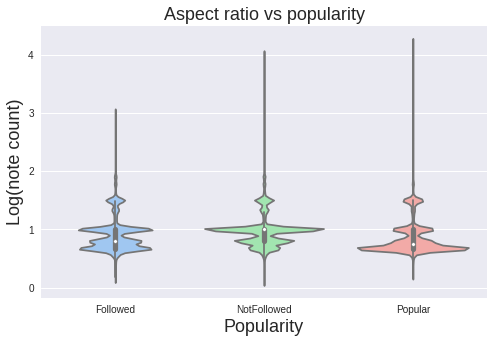

In [47]:
sns.set_palette("pastel")
sns.violinplot(x='Popularity',y='aspect_ratio',data=ststyle)
ax=plt.gca()
plt.title("Aspect ratio vs popularity",size=18)
plt.ylabel('Log(note count)',size=18)
plt.xlabel('Popularity',size=18)
fig=plt.gcf()
fig.savefig('aspect_ratio_02_17_default.png')#, transparent=True)
plt.show()

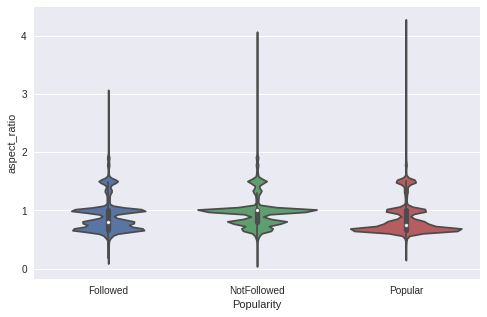

In [183]:
sns.violinplot(x='Popularity',y='aspect_ratio',data=ststyle)
ax=plt.gca()
plt.title("Aspect ratio",color='white')
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['left'].set_color('white')
ax.spines['right'].set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
plt.ylabel('Log(note count)',color='white')
plt.xlabel('Hour of the day',color='white')
fig=plt.gcf()
fig.savefig('hour_02_17.png', transparent=True)
plt.show()

### Tags and words

In [36]:
ststyle['taglist'].isnull().sum()

748

A useful variable that may influence a follower is the tag content of the post. I will create a variable defining the number of tags each post has from a set of 'trending tags'
The code below extracts the top N frequent words form the taglist variable, excluding synonyms (or similar words) of the tags used to collect the posts and the actual tags.

In [37]:
import re
import fuzzywuzzy 
from fuzzywuzzy import fuzz
import operator

def tagextractor(taglist,N):
    '''Extracts the top N frequent words from the taglist column of the posts dataframe
    where each row is a set of tags such like: ' "street style","streetstyle","fashion" '
    '''
    #N number of top repeated words
    
    array_tags=[]
#nested list size 20000
    for i,row in enumerate(taglist):
        r=[]
        if not pd.isnull(row):
            s=re.findall(r'"[a-zA-Z\s]*"',row)
            for item in s:
                r.append(re.sub(r'[^a-zA-Z ]','',item))
            array_tags.append(r)
        else:
            array_tags.append('')
#flatten and clean list to search for most frequent
    flatten_tags=[]
    for i,row in enumerate(taglist):
        if not pd.isnull(row):
            s=re.findall(r'"[a-zA-Z\s]*"',row)
            for item in s:
                flatten_tags.append(re.sub(r'[^a-zA-Z ]','',item))
        else:
            flatten_tags.append('')
    # remove the tags I used to find the posts
    flatten=[w for w in flatten_tags if re.search(r'street',w)is None \
             and re.search(r'fashion',w)is None \
             and re.search(r'style',w) is None\
            and re.search(r'fashion',w)is None \
             and re.search(r'wear',w) is None\
             and re.search(r'moda',w) is None\
            and re.search(r'cloth',w) is None\
            and re.search(r'men',w) is None\
            and re.search(r'outfit',w) is None\
             and re.search(r'ootd',w) is None\
            and re.search(r'man',w) is None\
            and re.search(r'male',w) is None\
            and re.search(r'girl',w) is None\
            and re.search(r'woman',w) is None\
            and re.search(r'curvy',w) is None]
    flatten.remove('')
     #streetstyle,street_style,mens_wear,menswear,mensfashion,mensfashion,fashion,high_fashion
    ## find similar misspelled words and drop similars before counting
    ## fuzz.token_set_ratio(x,y) compares x and y and gives probability of similarity,
    # >65 are probably the same Proper nouns
        
        
    word_counter = {}
    for word in flatten:
        if word in word_counter:
            word_counter[word] += 1
        else:
            word_counter[word] = 1
    del word_counter['']
    popular_words = sorted(word_counter, key = word_counter.get, reverse = True)
    popular_freq=sorted(word_counter.items(), key=operator.itemgetter(1),reverse=True) 
    top = popular_words[:N]
    
    return array_tags,top,flatten

def wordextractor(wordlist,N):

    words_list=[row.split() for row in wordlist]
    flatten_words=[item for sublist in words_list for item in sublist]
    flatten=[w for w in flatten_words if re.search(r'street.',w)is None\
             and re.search(r'fashion.',w)is None\
             and re.search(r'style.',w) is None \
             and re.search(r'womenswear. ',w) is None\
            and re.search(r'menswear. ',w) is None]        
  
    word_counter = {}
    for word in flatten:
        if word in word_counter:
            word_counter[word] += 1
        else:
            word_counter[word] = 1
    popular_words = sorted(word_counter, key = word_counter.get, reverse = True)
    popular_freq=sorted(word_counter.items(), key=operator.itemgetter(1),reverse=True) 
    top = popular_words[:N]
    
    return words_list,top,flatten



In [38]:
array_tags,topN,ftags=tagextractor(ststyle['taglist'],200)
array_word,topNw,fword=wordextractor(ststyle['words'].fillna(''),200)

In [39]:
topN

['model ',
 'photography ',
 'dapper ',
 'stylish ',
 'nyfw ',
 'luxury ',
 'love ',
 'runway ',
 'lookbook ',
 'trend ',
 'instagood ',
 'pico ',
 'suit ',
 'blogger ',
 'urban ',
 's ',
 'swag ',
 'dope ',
 'beautiful ',
 'hypebeast ',
 'art ',
 'model duty ',
 'dress ',
 'shoe ',
 'summer ',
 'haute couture ',
 'photooftheday ',
 'couture ',
 'celebs ',
 'nyc ',
 'vintage ',
 'vogue ',
 'picoftheday ',
 'beauty ',
 'apparel ',
 'design ',
 'follow ',
 'photo ',
 'cute ',
 'editorial ',
 'inspiration ',
 'gq ',
 'classy ',
 'hot ',
 'hipster ',
 'paris ',
 'black ',
 'casual ',
 'denim ',
 'fw ',
 'blog ',
 'designer ',
 'prom dress ',
 'hair ',
 'look ',
 'pfw ',
 'likelike ',
 'lookoftheday ',
 'grunge ',
 'class ',
 'sneaker ',
 'indie ',
 'handsome ',
 'newyork ',
 'candids ',
 'trendy ',
 'adidas ',
 'instagram ',
 'london ',
 'detail ',
 'accessory ',
 'victoria secret ',
 'stylist ',
 'shirt ',
 'chic ',
 'travel ',
 'fall ',
 'supreme ',
 'life ',
 'instadaily ',
 'fresh ',
 

In [60]:
len(ststyle)

83283

#### Creating a variable defined as: number of tags in each row that belong to the topN

In [40]:
#topN
#array_tags
#number of times any tag appears in set topN

freq_tags=[]
count=0
for tags in array_tags:
    count=0
    for tag in tags:
        if tag in topN:
            count+=1
    freq_tags.append(count)

ststyle['freq_tags']=freq_tags

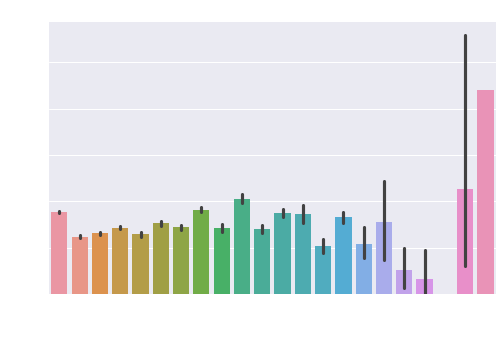

In [111]:
sns.barplot(x='freq_tags',y='note_countlog',data=ststyle)
ax=plt.gca()
plt.title("mean(note count) vs freq_tags",color='white',size=18)
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['left'].set_color('white')
ax.spines['right'].set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
plt.title('Mean note count vs # frequent tags')
plt.ylabel('mean (log(note count))',color='white',size=18)
plt.xlabel('# frequent tags',color='white',size=18)
fig=plt.gcf()
fig.savefig('freq_tags_02_17.png', transparent=True)
plt.show()

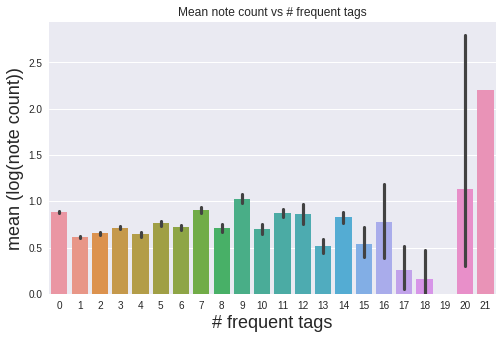

In [41]:
sns.barplot(x='freq_tags',y='note_countlog',data=ststyle)
ax=plt.gca()
plt.title("mean(note count) vs freq_tags",size=18)
plt.title('Mean note count vs # frequent tags')
plt.ylabel('mean (log(note count))',size=18)
plt.xlabel('# frequent tags',size=18)
fig=plt.gcf()
fig.savefig('freq_tags_02_17_default.png', transparent=True)
plt.show()

### Building training data

In [116]:
list(ststyle)

['Unnamed: 0',
 'id',
 'num_photos',
 'photo_ratio',
 'words',
 'wcount',
 'taglist',
 'cphotos',
 'blog_name',
 'date',
 'note_count',
 'short_url',
 'source_title',
 'photoset_layout',
 'note_countlog',
 'Followed',
 'Popularity',
 'hour',
 'Date_',
 'isfreq',
 'isfreql',
 'aspect_ratio',
 'freq_tags']

In [64]:
writetofile=ststyle.loc[:,['note_countlog','wcount','hour','aspect_ratio','freq_tags','Popularity']]
writetofile.to_csv('data_02_17.csv')

## Machine learning algorithm

### Binary classification

#### Partitioning the dataset: train and  validation: (80: 80/20), test 20


In [44]:
import sklearn
import random
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

#from sklearn.tree import DecisionTreeClassifier



random.seed(123)

#Partitioning by hand 
#x = numpy.random.rand(100, 5)
#indices = numpy.random.permutation(x.shape[0])
#training_idx, test_idx = indices[:80], indices[80:]
#training, test = x[training_idx,:], x[test_idx,:]


X = ststyle.loc[:,['num_photos','aspect_ratio','wcount','hour','freq_tags','isfreq','isfreql']]
y = ststyle.loc[:,'Followed']
X['aspect_ratio'] = X['aspect_ratio'].fillna(X['aspect_ratio'].mean())

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5)

#[X[x].isnull().sum() for x in list(x_train)] #Making sure with don't have na's

#For such a small proportion of na's 460/20000 it's reasonable to replace with the mean




In [66]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83283 entries, 0 to 327
Data columns (total 7 columns):
num_photos      83283 non-null float64
aspect_ratio    83283 non-null float64
wcount          83283 non-null float64
hour            83283 non-null int64
freq_tags       83283 non-null int64
isfreq          83283 non-null int64
isfreql         83283 non-null int64
dtypes: float64(3), int64(4)
memory usage: 7.6 MB


In [193]:

models=[]
models.append(('LR',LogisticRegression()))
models.append(('LDA',LinearDiscriminantAnalysis()))
models.append(('KNN',KNeighborsClassifier()))
#models.append(('DTC',DecisionTreeClassifier()))
models.append(('RFC',RandomForestClassifier(n_estimators=100)))
models.append(('AdB',AdaBoostClassifier(n_estimators=100)))



print 'Accuracy for each algorithm'

results=[]
names=[]
scoring='accuracy'

for name,model in models:
    kfold=RepeatedKFold(n_splits=5,n_repeats=3,random_state=123)
    cv_results=cross_val_score(model,x_train,y_train,cv=kfold,scoring=scoring)
    results.append(cv_results)
    names.append(name)
    mod=model
    mod.fit(x_train,y_train)
    mod_pred=mod.predict(x_val)
    mod_accuracy=accuracy_score(mod_pred,y_val)
    msg='CV accuracy %s:, %f SD %f - Validation  accuracy: %f ' % (name, cv_results.mean(),cv_results.std(),mod_accuracy)
    print(msg)




Accuracy for each algorithm
CV accuracy LR:, 0.799787 SD 0.003762 - Validation  accuracy: 0.790523 
CV accuracy LDA:, 0.799759 SD 0.003797 - Validation  accuracy: 0.790603 
CV accuracy KNN:, 0.810662 SD 0.003767 - Validation  accuracy: 0.811094 
CV accuracy RFC:, 0.846799 SD 0.003265 - Validation  accuracy: 0.848555 
CV accuracy AdB:, 0.808004 SD 0.004032 - Validation  accuracy: 0.799568 


In [38]:
random.seed(123)
#kfold=RepeatedKFold(n_splits=5,n_repeats=3,random_state=123)
rfmodel=RandomForestClassifier(n_estimators=100)
rfmodel.fit(x_train,y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [195]:
pred=rfmodel.predict(x_test)
tn, fp, fn, tp = confusion_matrix(y_test,pred).ravel()

acc=(tp+tn*1.)/(tn+tp+fn+fp)
print acc
print (tn, fp, fn, tp)

0.848623118796
(9267, 626, 1265, 1334)


In [196]:
from sklearn.externals import joblib
joblib.dump(rfmodel, 'rfmodel_ststyle_02_17.pkl') 

['rfmodel_ststyle_02_17.pkl']

Let's look at the receiving operating characteristic curve for the binary classification

In [197]:
random.seed(123)

#y_score = svmodel.fit(x_train, y_train).decision_function(x_test)
#fpr = dict()
#tpr = dict()
#roc_auc = dict()

#fpr, tpr, thresh = roc_curve(y_test, y_score)
#roc_auc = auc(fpr, tpr)
#rocpoints=pd.DataFrame(np.transpose([fpr, tpr, thresh,tpr/fpr]))

pred_prob=rfmodel.predict_proba(x_test)[:, 1]
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr, tpr, thresh = roc_curve(y_test, pred_prob)
roc_auc = auc(fpr, tpr)


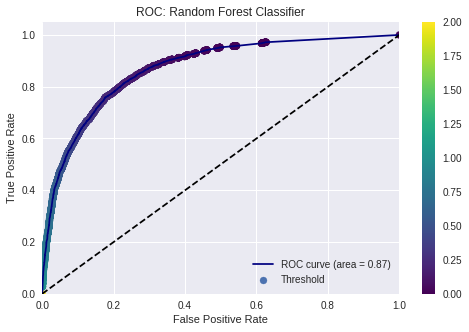

In [199]:

plt.plot(fpr, tpr, color='navy', label='ROC curve (area = %0.2f)' % roc_auc)
plt.scatter(fpr, tpr, c=thresh, cmap='viridis', label='Threshold')
plt.colorbar()
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: Random Forest Classifier')
plt.legend(loc="lower right")
plt.show()
plt.draw()


#### Classification accuracy is 87%

Let us comapre with the null accuracy: accuracy that could be achieved by always predicting the most frequent class (Not followed)

In [200]:
print y_test.mean()

# calculate the percentage of zeros
print 1 - y_test.mean()

# calculate null accuracy in a single line of code
# only for binary classification problems coded as 0/1
print max(y_test.mean(), 1 - y_test.mean())

#This means that a dumb model that always predicts 0 would be right 80% of the time
#This shows how classification accuracy is not that good as it's close to a dumb model
#It's a good way to know the minimum we should achieve with our models

0.208053154019
0.791946845981
0.791946845981


In [201]:
print 'Accuracy %f:'%(acc)
print 'Confusion matrix: (tn,fp,fn,tp)'
print (tn, fp, fn, tp)

classification_error = (fp + fn) / float(tp + tn + fp + fn)

print('Classification error: %f' % (classification_error))
print(1 - accuracy_score(y_test, pred))

sensitivity = tp / float(fn + tp)
recall=sensitivity
print('Sensitivity/Recall/TPR: %f'% recall)
print(recall_score(y_test, pred))

specificity = tn / float(tn + fp)

print('Specificity : %f' %(specificity))

false_positive_rate = fp / float(tn + fp)

print('False positive rate :%f'% (false_positive_rate))
print(1 - specificity)

precision = tp / float(tp + fp)

print('Precision %f:'%(precision))
print(precision_score(y_test, pred))

f1score= 2*(precision*recall)/(precision+recall)
print ('F1score :%f'%(f1score))

Accuracy 0.848623:
Confusion matrix: (tn,fp,fn,tp)
(9267, 626, 1265, 1334)
Classification error: 0.151377
0.151376881204
Sensitivity/Recall/TPR: 0.513274
0.513274336283
Specificity : 0.936723
False positive rate :0.063277
0.0632770645911
Precision 0.680612:
0.680612244898
F1score :0.585216


## Feature importance

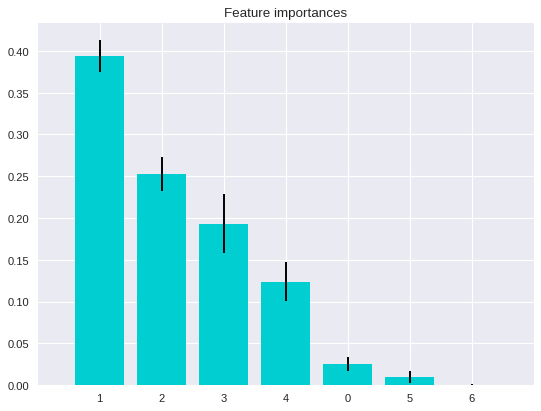

In [45]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=7,
                              random_state=123)

forest.fit(x_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_]
             ,axis=0)
indices = np.argsort(importances)[::-1]


# Plot the feature importances of the forest

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w'
           , edgecolor='k')


#font = {'family': 'sans-serif',
#            'color':  'white',
#            'weight': 'normal',
#            'size': 28,
#            }

plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices],
       color='darkturquoise', yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.suptitle('')
ax.set_title('')
ax = plt.gca()
#labels=['AR','WC','H','T']
#ax.set_xticklabels(labels,fontdict=font)

#ax.spines['bottom'].set_color('white')
#ax.spines['top'].set_color('white')
#ax.spines['left'].set_color('white')
#ax.spines['right'].set_color('white')
#ax.tick_params(axis='x', colors='white')
#ax.tick_params(axis='y', colors='white')
fig=plt.gcf()
fig.savefig('importance_transparent_default.png', transparent=True)
plt.show()

In [84]:
features_importance=pd.DataFrame(
    {'Ranking':range(1,x_train.shape[1]+1),
     'Feature':np.array(list(x_train))[indices],
     'Relevance':importances[indices]}).set_index('Ranking')
features_importance

,Feature,Relevance
Ranking,,
1,aspect_ratio,0.394997
2,wcount,0.238785
3,hour,0.205443
4,freq_tags,0.128721
5,num_photos,0.024052
6,isfreq,0.007538
7,isfreql,0.000464


# Machine learning Multiple classes 

In [84]:
cuta=ststyle['note_count'].quantile(q=.33)
cutb=ststyle['note_count'].quantile(q=.66)


print [cuta,cutb]

print len(ststyle.loc[ststyle['note_count']==cuta])
print len(ststyle.loc[(cuta<ststyle['note_count'])&(ststyle['note_count']<=cutb)])
print len(ststyle.loc[ststyle['note_count']>cutb])

[0.0, 7.0]
27824
27155
28304


In [85]:

ststyle['Popularity']=np.where(ststyle['note_count'] > 7, 'Popular', 
         (np.where(ststyle['note_count'] < 1, 'NotFollowed', 'Followed')))

#### This thresholds gave me .582
#### The q=.4, q=.8 thresholds gave me ~.60

In [86]:
random.seed(123)

#Partitioning by hand 
#x = numpy.random.rand(100, 5)
#indices = numpy.random.permutation(x.shape[0])
#training_idx, test_idx = indices[:80], indices[80:]
#training, test = x[training_idx,:], x[test_idx,:]
X = ststyle.loc[:,['num_photos','photo_ratio','wcount','hour','freq_tags','isfreq','isfreql']]
X['photo_ratio'] = X['photo_ratio'].fillna(X['photo_ratio'].mean())
y = ststyle.loc[:,'Popularity']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5)



#[X[x].isnull().sum() for x in list(x_train)] #Making sure with don't have na's

#For such a small proportion of na's 460/20000 it's reasonable to replace with the mean




In [81]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83283 entries, 0 to 327
Data columns (total 7 columns):
num_photos     83283 non-null float64
photo_ratio    83283 non-null float64
wcount         83283 non-null float64
hour           83283 non-null int64
freq_tags      83283 non-null int64
isfreq         83283 non-null int64
isfreql        83283 non-null int64
dtypes: float64(3), int64(4)
memory usage: 7.6 MB


In [87]:

models=[]
models.append(('LR',LogisticRegression(multi_class='ovr')))
#models.append(('KNN',KNeighborsClassifier(multi_class='ovr')))
#models.append(('DTC',DecisionTreeClassifier()))
models.append(('RFC',RandomForestClassifier()))
#models.append(('SVM',LinearSVC(multi_class='ovr')))

print 'Accuracy for each algorithm'

results=[]
names=[]
scoring='accuracy'

for name,model in models:
    kfold=RepeatedKFold(n_splits=5,n_repeats=3,random_state=123)
    cv_results=cross_val_score(model,x_train,y_train,cv=kfold,scoring=scoring)
    results.append(cv_results)
    names.append(name)
    mod=model
    mod.fit(x_train,y_train)
    mod_pred=mod.predict(x_val)
    mod_accuracy=accuracy_score(mod_pred,y_val)
    msg='CV accuracy %s:, %f SD %f - Validation  accuracy: %f ' % (name, cv_results.mean(),cv_results.std(),mod_accuracy)
    print(msg)




Accuracy for each algorithm
CV accuracy LR:, 0.489531 SD 0.003815 - Validation  accuracy: 0.491395 
CV accuracy RFC:, 0.659394 SD 0.004920 - Validation  accuracy: 0.691507 


In [88]:
random.seed(123)

model=RandomForestClassifier(n_estimators=20)

kfold=RepeatedKFold(n_splits=5,n_repeats=3,random_state=123)
cv_results=cross_val_score(model,x_train,y_train,cv=kfold,scoring=scoring)
results=(cv_results)
model.fit(x_train,y_train)
mod_pred=model.predict(x_val)


[[3023  726  371]
 [ 751 2563  870]
 [ 328  752 3108]]
Confusion matrix, without normalization
[[3023  726  371]
 [ 751 2563  870]
 [ 328  752 3108]]
Normalized confusion matrix
[[ 0.73  0.18  0.09]
 [ 0.18  0.61  0.21]
 [ 0.08  0.18  0.74]]


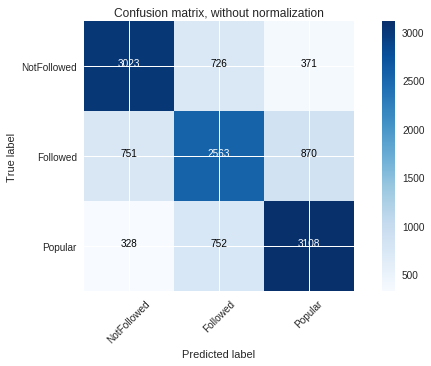

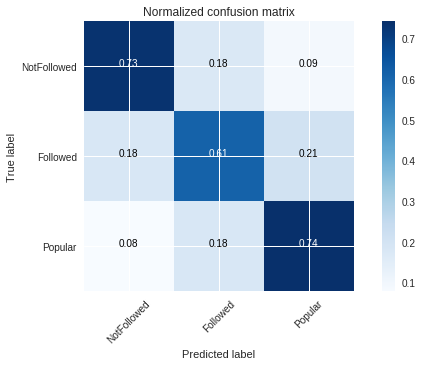

In [106]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    
labels =['NotFollowed','Followed','Popular']
cm = confusion_matrix(y_test, model.predict(x_test), labels)
print(cm)    
# Compute confusion matrix
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=labels,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()

plot_confusion_matrix(cm, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [92]:
mod_accuracy=accuracy_score(mod_pred,y_val)
print mod_accuracy
# 0.679820699592

0.68982630273


In [93]:
from sklearn.externals import joblib
joblib.dump(model, 'rfmodel_multi_02_17.pkl') 

['rfmodel_multi_02_17.pkl']

# Actionable insights (application)

In [70]:
thefile = open('topN.txt', 'w')
thefile.write("\n".join(topN))
fil=open('topN.txt','r')
lines = fil.read().splitlines()
lines


['model ',
 'stylish ',
 'love ',
 'model duty ',
 'swag ',
 'photography ',
 'instagood ',
 'nyfw ',
 'trend ',
 'celebs ',
 'urban ',
 'hypebeast ',
 'blogger ',
 'lookbook ',
 'beautiful ',
 'shoe ',
 'art ',
 'summer ',
 'apparel ',
 'grunge ',
 'nyc ',
 'photooftheday ',
 'candids ',
 'follow ',
 'beauty ',
 'photo ',
 'dope ',
 'cute ',
 'hipster ',
 'design ',
 's ',
 'picoftheday ',
 'indie ',
 'look ',
 'candid ',
 'paris ',
 'sexy ',
 'fresh ',
 'inspiration ',
 'denim ',
 'hot ',
 'kick ',
 'hair ',
 'vintage ',
 'newyork ',
 'gear ',
 'famous ',
 'luxury ',
 'black ',
 'travel ',
 'casual ',
 'lookoftheday ',
 'life ',
 'dress ',
 'hiphop ',
 'sneaker ',
 'instagram ',
 'likelike ',
 'adidas ',
 'instadaily ',
 'music ',
 'london ',
 'supreme ',
 'duty ',
 'designer ',
 'pfw ',
 'portrait ',
 'makeup ',
 'followme ',
 'kendall jenner ',
 'victoria secret ',
 'nike ',
 'actress ',
 'photoshoot ',
 'stylist ',
 'bella hadid ',
 'jean ',
 'trendy ',
 'august ',
 'graffiti ',
 

In [5]:
import cleantags_app

tagl=ststyle[ststyle['Popularity']=='Popular']['taglist']
taglnp=ststyle[ststyle['Popularity']=='NotFollowed']['taglist']
arraypop,topNpop=cleantags_app.tagextractor(tagl,50)
arraynp,topNnp=cleantags_app.tagextractor(taglnp,50)

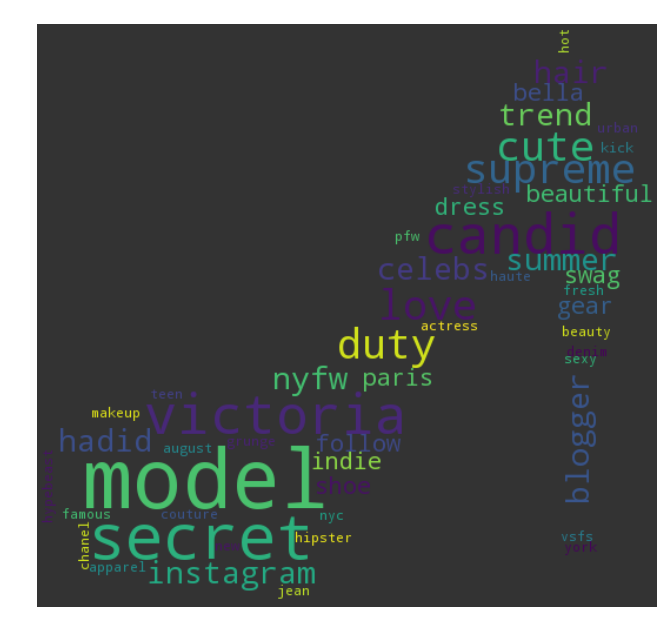

In [11]:
from os import path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS


plt.figure(num=None, figsize=(10,12), dpi=80, facecolor='w', edgecolor='k')
# Read the whole text.
text = ' '.join(topNpop)

# read the mask image
# taken from
# http://www.stencilry.org/stencils/movies/alice%20in%20wonderland/255fk.jpg
stiletto_mask = np.array(Image.open("data/image10.png"))

stopwords = set(STOPWORDS)
stopwords.add("said")

wc = WordCloud(background_color='#333333', max_words=200, mask=stiletto_mask,
               stopwords=stopwords)
# generate word cloud
wc.generate(text)

# store to file
wc.to_file( "cloud_popular.png")

# show
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
fig1 = plt.gcf()

plt.show()
plt.draw()
#fig1.savefig('cloud.png',transparent=True)

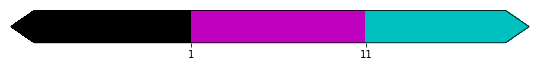

In [331]:
import matplotlib.pyplot as plt
import matplotlib as mpl

fig = plt.figure(figsize=(8, 3))

ax2 = fig.add_axes([0.05, 0.475, 0.9, 0.15])

cmap = mpl.colors.ListedColormap(['k','m', 'c'])
cmap.set_over('0.25')
cmap.set_under('0.75')

# If a ListedColormap is used, the length of the bounds array must be
# one greater than the length of the color list.  The bounds must be
# monotonically increasing.
bounds = [-8,1, 11,19]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb2 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,
                                norm=norm,
                                # to use 'extend', you must
                                # specify two extra boundaries:
                                boundaries=[0] + bounds + [13],
                                extend='both',
                                ticks=[1,11],  # optional
                                spacing='proportional',
                                orientation='horizontal')
#cb2.set_label('Level of influence')

plt.show()